<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Importar os módulos

In [413]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import Miguel_Dataset_transf as dprep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
#from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve, precision_score, recall_score,confusion_matrix,f1_score,fbeta_score, make_scorer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Obter os dataframes dos ficheiros

In [414]:
metrics_dict={}
tentativa = 0

In [415]:
failures_df, signals_df, logs_df = dprep.get_data()

In [416]:
failures_df[failures_df.Component == 'TRANSFORMER'].sort_values('Timestamp')

,Turbine_ID,Component,Timestamp
4,T07,TRANSFORMER,2016-07-10 03:40:00
9,T07,TRANSFORMER,2016-08-23 02:20:00
19,T01,TRANSFORMER,2017-08-11 13:10:00


In [417]:
failures_df.Component.value_counts()

GENERATOR            7
GENERATOR_BEARING    6
HYDRAULIC_GROUP      5
TRANSFORMER          3
GEARBOX              2
Name: Component, dtype: int64

In [418]:
df_list = [failures_df, signals_df, logs_df]

# Criação de datasets de components

In [419]:
df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox = dprep.component_df_creation(signals_df)

In [420]:
comp_df_list = [df_generator, df_hydraulic, df_gen_bear, df_transformer,  df_gearbox]

In [421]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(434145, 45)
(434145, 34)
(434145, 45)
(434145, 36)
(434145, 33)


In [422]:
component_list = failures_df.Component.unique()
component_list

array(['GENERATOR', 'HYDRAULIC_GROUP', 'GENERATOR_BEARING', 'TRANSFORMER',
       'GEARBOX'], dtype=object)

# Cópia dos df para só carregar uma vez no ficheiro

In [423]:
comp_prep_df_list = comp_df_list.copy()

# Merge dos DF com o DF de failures

In [424]:
for i in range(len(component_list)):
    comp_prep_df_list[i] = dprep.sig_fail_merge_dfs(sig_df=comp_prep_df_list[i],
                                               fail_df=failures_df,
                                               component=component_list[i])

In [425]:
for i in comp_df_list:
    print(i.shape)

(434145, 45)
(434145, 34)
(434145, 45)
(434145, 36)
(434145, 33)


# Fillna by turbine

In [426]:
turbine_list = signals_df.Turbine_ID.unique()
turbine_list

array(['T11', 'T06', 'T01', 'T09', 'T07'], dtype=object)

In [427]:
for i in range(len(component_list)):
    comp_prep_df_list[i] = dprep.fill_na_by_turbine(comp_prep_df_list[i], turbine_list)

/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Miguel_Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Miguel_Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Miguel_Dataset_transf.py:170: SettingWithCopyWarning: 
A value is

/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Miguel_Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Miguel_Dataset_transf.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['date'] = df_merged['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Miguel_Dataset_transf.py:171: SettingWithCopyWarning: 
A 

In [428]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 47)
(434145, 36)
(434145, 47)
(434145, 38)
(434145, 35)


# Criação de Variável alvo

In [429]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].isna().sum().value_counts())

0    47
dtype: int64
0    36
dtype: int64
0    47
dtype: int64
0    38
dtype: int64
0    35
dtype: int64


In [430]:
days_list = [60,50,40,30,20,10]

In [431]:
for day in days_list:
    for i in range(len(comp_prep_df_list)):
        comp_prep_df_list[i] = dprep.aplic_var_target(comp_prep_df_list[i], day)

In [432]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 53)
(434145, 42)
(434145, 53)
(434145, 44)
(434145, 41)


# Feature selection

In [433]:
for i in comp_prep_df_list:
    print(i.keys().shape)

(53,)
(42,)
(53,)
(44,)
(41,)


In [434]:
gen_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [435]:
gen_bear_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [436]:
hyd_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Blds_PitchAngle_Max', 'Grd_RtrInvPhase3_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Spin_Temp_Avg', 'Cont_Hub_Temp_Avg',
    'Grd_RtrInvPhase1_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [437]:
gearbox_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max',
    'Cont_VCP_Temp_Avg', 'Grd_Busbar_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg'
]

In [438]:
transf_features_drop = [
    'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Max',
    'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg',
    'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [439]:
feat_drop_list = [
    gen_features_drop, hyd_features_drop, gen_bear_features_drop,
    transf_features_drop, gearbox_features_drop
]

In [440]:
for df in range(len(comp_prep_df_list)):
    print(f'A actualizar dataframe {df+1} de {len(comp_prep_df_list)}')
#     for col in feat_drop_list:
#         print(f'A apagar a coluna {col}')
    comp_prep_df_list[df] = comp_prep_df_list[df].drop(columns=feat_drop_list[df])

A actualizar dataframe 1 de 5
A actualizar dataframe 2 de 5
A actualizar dataframe 3 de 5
A actualizar dataframe 4 de 5
A actualizar dataframe 5 de 5


In [441]:
for i in comp_prep_df_list:
    print(i.shape)

(434147, 36)
(434145, 31)
(434145, 36)
(434145, 33)
(434145, 31)


In [442]:
for i in comp_prep_df_list:
    print(i.keys().shape)

(36,)
(31,)
(36,)
(33,)
(31,)


# Agrupar pela medida de tempo seleccionada.

In [443]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(434147, 36)
(434145, 31)
(434145, 36)
(434145, 33)
(434145, 31)


In [444]:
# Passagem para dias
Agrup_por = 'Dia'
for i in range(len(comp_prep_df_list)):
    comp_prep_df_list[i] = dprep.group_por_frequency(comp_prep_df_list[i], period=Agrup_por)

In [445]:
# Passagem para dias 
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(3042, 36)
(3041, 24)
(3041, 23)
(3041, 24)
(3041, 21)


# Adicionar as medidas de alisamento

In [446]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(3042, 36)
(3041, 24)
(3041, 23)
(3041, 24)
(3041, 21)


In [447]:
for i in range(len(comp_prep_df_list)):
    comp_prep_df_list[i] = dprep.add_features(comp_prep_df_list[i], rolling_win_size=10)

In [467]:
comp_prep_df_list[0]

,Turbine_ID,Date,Component,TTF,60_days,50_days,40_days,30_days,20_days,10_days,...,Blds_PitchAngle_Avg_sd,Blds_PitchAngle_Std_sd,Cont_Top_Temp_Avg_sd,Cont_VCP_ChokcoilTemp_Avg_sd,Cont_VCP_WtrTemp_Avg_sd,Nac_Temp_Avg_sd,Nac_Direction_Avg_sd,Grd_Busbar_Temp_Avg_sd,Hyd_Oil_Temp_Avg_sd,Component_sd
0,T01,2016-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,T01,2016-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.342616,0.481225,2.013290,17.314295,2.852979,0.623629,45.821993,3.353847,0.112941,0.0
2,T01,2016-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.260387,0.493652,1.639850,13.783015,2.737418,0.728086,44.775715,3.045330,0.612648,0.0
3,T01,2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.094254,0.405716,2.890193,22.641818,3.197012,2.494331,45.540714,4.936933,3.511506,0.0
4,T01,2016-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.999738,0.355305,2.556940,22.954628,2.776914,2.169350,55.760338,4.519062,4.098536,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,T11,2017-08-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.649136,0.745409,2.651354,13.857214,2.664959,2.002183,53.547211,3.389170,3.260078,0.0
3038,T11,2017-08-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.549805,0.804185,3.207846,13.945935,3.141506,2.677829,59.263124,3.797639,3.720216,0.0
3039,T11,2017-08-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.985188,0.823226,3.319002,16.792784,3.308717,2.678508,57.862229,3.724118,3.406787,0.0
3040,T11,2017-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.697543,0.829865,2.594377,13.837212,2.608279,2.484162,58.351777,2.481400,2.304921,0.0


In [448]:
cols_to_drop = [
    'Amb_Temp_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
    'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
    'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
    'Cont_Top_Temp_Avg', 'Cont_VCP_ChokcoilTemp_Avg',
    'Cont_VCP_WtrTemp_Avg', 'Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg',
    'Gen_Phase2_Temp_Avg', 'Gen_RPM_Avg', 'Gen_RPM_Std',
    'Gen_SlipRing_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Grd_RtrInvPhase2_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Nac_Direction_Avg',
    'Nac_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
    'Prod_LatestAvg_ReactPwrGen0'
]
comp_prep_df_list[0] = comp_prep_df_list[0].drop(columns=cols_to_drop)

In [449]:
cols_to_drop = [
    'Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
    'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
    'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
    'Nac_Direction_Avg', 'Rtr_RPM_Avg', 'Rtr_RPM_Std'
]
comp_prep_df_list[1] = comp_prep_df_list[1].drop(columns=cols_to_drop)

In [450]:
cols_to_drop =  ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Gen_Bear_Temp_Avg', 'Gen_RPM_Avg', 'Gen_RPM_Std',
       'Nac_Direction_Avg', 'Prod_LatestAvg_ActPwrGen1']
comp_prep_df_list[2] = comp_prep_df_list[2].drop(columns=cols_to_drop)

In [451]:
cols_to_drop = ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Grd_Prod_VoltPhse1_Avg', 'Grd_Prod_VoltPhse2_Avg',
       'Grd_Prod_VoltPhse3_Avg', 'Nac_Direction_Avg', 'Rtr_RPM_Avg',
       'Rtr_RPM_Std']
comp_prep_df_list[3] = comp_prep_df_list[3].drop(columns=cols_to_drop)

In [452]:
cols_to_drop = ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Nac_Direction_Avg', 'Rtr_RPM_Avg', 'Rtr_RPM_Std']
comp_prep_df_list[4] = comp_prep_df_list[4].drop(columns=cols_to_drop)

In [453]:
for i in range(len(comp_prep_df_list)):
    print(comp_prep_df_list[i].shape)

(3042, 64)
(3041, 43)
(3041, 38)
(3041, 40)
(3041, 34)


# Train and test split

In [454]:
# Separar os dataframes de treino e teste
df_train = [0, 0, 0, 0, 0]
df_test = [0, 0, 0, 0, 0]

per_test = '3meses'

for i in range(len(comp_prep_df_list)):
    df_train[i] = dprep.prepare_train_df(comp_prep_df_list[i].copy(), meses=3)
    df_test[i] = dprep.prepare_test_df(comp_prep_df_list[i].copy(), meses=3)

In [455]:
for i in range(len(df_train)):
    print(f'df_train {i} com a forma {df_train[i].shape}')
    print(f'df_test {i} com a forma {df_test[i].shape}')

df_train 0 com a forma (2577, 64)
df_test 0 com a forma (465, 64)
df_train 1 com a forma (2576, 43)
df_test 1 com a forma (465, 43)
df_train 2 com a forma (2576, 38)
df_test 2 com a forma (465, 38)
df_train 3 com a forma (2576, 40)
df_test 3 com a forma (465, 40)
df_train 4 com a forma (2576, 34)
df_test 4 com a forma (465, 34)


In [456]:
df_train_generator   = df_train[0].drop(columns=['Component_av','Component_sd'])
df_train_hydraulic   = df_train[1].drop(columns=['Component_av','Component_sd'])
df_train_gen_bear    = df_train[2].drop(columns=['Component_av','Component_sd'])
df_train_transformer = df_train[3].drop(columns=['Component_av','Component_sd'])
df_train_gearbox_aux     = df_train[4].drop(columns=['Component_av','Component_sd'])

df_test_generator   = df_test[0].drop(columns=['Component_av','Component_sd'])
df_test_hydraulic   = df_test[1].drop(columns=['Component_av','Component_sd'])
df_test_gen_bear    = df_test[2].drop(columns=['Component_av','Component_sd'])
df_test_transformer = df_test[3].drop(columns=['Component_av','Component_sd'])
df_test_gearbox_aux     = df_test[4].drop(columns=['Component_av','Component_sd'])

In [457]:
df_train_generator   = df_train_generator[df_train_generator['Turbine_ID'].isin(['T11','T06'])]
df_train_hydraulic   = df_train_hydraulic[df_train_hydraulic['Turbine_ID'].isin(['T06','T11'])]
df_train_gen_bear    = df_train_gen_bear[df_train_gen_bear['Turbine_ID'].isin(['T07','T09'])]
df_train_transformer = df_train_transformer[df_train_transformer['Turbine_ID'].isin(['T07'])]
df_train_gearbox     = df_train_gearbox[df_train_gearbox['Turbine_ID'].isin(['T09'])]


In [458]:
df_test_gearbox=df_train_gearbox_aux[(df_train_gearbox_aux['Date']>='2016-01-01') & (df_train_gearbox_aux['Date']<='2016-07-31')]
train_part_1=df_train_gearbox_aux[(df_train_gearbox_aux['Date']>'2016-07-31')]
df_train_gearbox=pd.concat([train_part_1, df_test_gearbox_aux])


# Bloco Normalizar

In [296]:
list_var_target=[]
cols_to_drop_train = ['Date', 'TTF', 'Component']

for day in days_list:
    list_var_target.append(str(day)+'_days')
    
for var in list_var_target:
    cols_to_drop_train.append(var)



In [297]:
X_VAR_df_train_generator=df_train_generator.drop(columns=cols_to_drop_train)
X_VAR_df_train_hydraulic=df_train_hydraulic.drop(columns=cols_to_drop_train)
X_VAR_df_train_gen_bear=df_train_gen_bear.drop(columns=cols_to_drop_train)
X_VAR_df_train_transformer=df_train_transformer.drop(columns=cols_to_drop_train)
X_VAR_df_train_gearbox=df_train_gearbox.drop(columns=cols_to_drop_train)


X_VAR_df_test_generator=df_test_generator.drop(columns=cols_to_drop_train)
X_VAR_df_test_hydraulic=df_test_hydraulic.drop(columns=cols_to_drop_train)
X_VAR_df_test_gen_bear=df_test_gen_bear.drop(columns=cols_to_drop_train)
X_VAR_df_test_transformer=df_test_transformer.drop(columns=cols_to_drop_train)
X_VAR_df_test_gearbox=df_test_gearbox.drop(columns=cols_to_drop_train)


In [298]:
X_VAR_df_train_generator,   X_VAR_df_test_generator   = dprep.scale(X_VAR_df_train_generator,   X_VAR_df_test_generator)
X_VAR_df_train_hydraulic,   X_VAR_df_test_hydraulic   = dprep.scale(X_VAR_df_train_hydraulic,   X_VAR_df_test_hydraulic )
X_VAR_df_train_gen_bear,    X_VAR_df_test_gen_bear    = dprep.scale(X_VAR_df_train_gen_bear,    X_VAR_df_test_gen_bear )
X_VAR_df_train_transformer, X_VAR_df_test_transformer = dprep.scale(X_VAR_df_train_transformer, X_VAR_df_test_transformer )
X_VAR_df_train_gearbox,     X_VAR_df_test_gearbox     = dprep.scale(X_VAR_df_train_gearbox,     X_VAR_df_test_gearbox )

In [299]:
col_gen=df_test_generator.drop(columns=cols_to_drop_train).drop(columns='Turbine_ID').columns
col_hydraulic=df_test_hydraulic.drop(columns=cols_to_drop_train).drop(columns='Turbine_ID').columns
col_gen_bear=df_test_gen_bear.drop(columns=cols_to_drop_train).drop(columns='Turbine_ID').columns
col_transformer=df_test_transformer.drop(columns=cols_to_drop_train).drop(columns='Turbine_ID').columns
col_gearbox=df_test_gearbox.drop(columns=cols_to_drop_train).drop(columns='Turbine_ID').columns


In [300]:
df_1_train=pd.DataFrame(X_VAR_df_train_generator, columns=col_gen)
df_2_train=pd.DataFrame(X_VAR_df_train_hydraulic, columns=col_hydraulic)
df_3_train=pd.DataFrame(X_VAR_df_train_gen_bear, columns=col_gen_bear)
df_4_train=pd.DataFrame(X_VAR_df_train_transformer, columns=col_transformer)
df_5_train=pd.DataFrame(X_VAR_df_train_gearbox, columns=col_gearbox)


df_1_test=pd.DataFrame(X_VAR_df_test_generator, columns=col_gen)
df_2_test=pd.DataFrame(X_VAR_df_test_hydraulic, columns=col_hydraulic)
df_3_test=pd.DataFrame(X_VAR_df_test_gen_bear, columns=col_gen_bear)
df_4_test=pd.DataFrame(X_VAR_df_test_transformer, columns=col_transformer)
df_5_test=pd.DataFrame(X_VAR_df_test_gearbox, columns=col_gearbox)


In [301]:
cols_to_drop_train_bis=cols_to_drop_train.copy()
cols_to_drop_train_bis.append('Turbine_ID')

In [302]:
for var in cols_to_drop_train_bis:
    df_1_train[var]=df_train_generator[var].values
    
for var in cols_to_drop_train_bis:
    df_2_train[var]=df_train_hydraulic[var].values

for var in cols_to_drop_train_bis:
    df_3_train[var]=df_train_gen_bear[var].values

for var in cols_to_drop_train_bis:
    df_4_train[var]=df_train_transformer[var].values
    
for var in cols_to_drop_train_bis:
    df_5_train[var]=df_train_gearbox[var].values


In [303]:
for var in cols_to_drop_train_bis:
    df_1_test[var]=df_test_generator[var].values
    
for var in cols_to_drop_train_bis:
    df_2_test[var]=df_test_hydraulic[var].values

for var in cols_to_drop_train_bis:
    df_3_test[var]=df_test_gen_bear[var].values

for var in cols_to_drop_train_bis:
    df_4_test[var]=df_test_transformer[var].values
    
for var in cols_to_drop_train_bis:
    df_5_test[var]=df_test_gearbox[var].values


In [304]:
#df_train_generator   = df_1_train
#df_train_hydraulic   = df_2_train
#df_train_gen_bear    = df_3_train
#df_train_transformer = df_4_train
#df_train_gearbox_aux     = df_5_train

In [305]:
df_train_generator   = df_1_train[df_1_train['Turbine_ID'].isin(['T11','T06'])]
df_train_hydraulic   = df_2_train[df_2_train['Turbine_ID'].isin(['T06','T11'])]
df_train_gen_bear    = df_3_train[df_3_train['Turbine_ID'].isin(['T07','T09'])]
df_train_transformer = df_4_train[df_4_train['Turbine_ID'].isin(['T07'])]
df_train_gearbox     = df_5_train[df_5_train['Turbine_ID'].isin(['T09'])]


In [306]:
df_test_generator   =  df_1_test
df_test_hydraulic   =  df_2_test
df_test_gen_bear    =  df_3_test
df_test_transformer =  df_4_test
df_test_gearbox_aux =  df_5_test

In [524]:
def classifier(model, clf, features,target, df_train, df_test, key_target, key_df ,params=None, score=None, ):
    
    X_train = df_train_[features]

    X_test = df_test_[features] 
    y_train = df_train_[target]
    y_test = df_test_[target]

    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_test_pred_default = grid_search.predict(X_test)
    y_train_pred_default = grid_search.predict(X_train)

    
    if hasattr(grid_search, 'predict_proba'):   
        y_test_prob = grid_search.predict_proba(X_test)[:,1]
        y_train_prob = grid_search.predict_proba(X_train)[:,1]
        
    elif hasattr(grid_search, 'decision_function'):
        y_test_prob = grid_search.decision_function(X_test)
        y_train_prob = grid_search.decision_function(X_train)
        
        
    else:
        y_test_prob = y_pred_test
        y_train_prob = y_pred_train
        
    #print(f'alo{key_target}')
    #print(dict_thresholds[key_df][key_target])
    
    
    y_test_pred_aux = y_test_prob>=dict_thresholds[key_df][key_target]
    y_test_pred = np.where(y_test_pred_aux==True, 1, 0)
    
    y_train_pred_aux = y_train_prob>=dict_thresholds[key_df][key_target]
    y_train_pred =  np.where(y_train_pred_aux==True, 1, 0)
    

        
    predictions_test = {'y_test_pred' : y_test_pred, 'y_test_prob' : y_test_prob}
    predictions_train = {'y_train_pred' : y_train_pred, 'y_train_prob' : y_train_prob}
   
    df_predictions_test = pd.DataFrame.from_dict(predictions_test)
    df_predictions_train = pd.DataFrame.from_dict(predictions_train)

    
    return grid_search.best_estimator_, df_predictions_test,df_predictions_train

In [503]:
def metrics (y_train, y_train_prob, y_test, y_test_pred, y_test_prob):
    cm2 = confusion_matrix(y_test.values,y_test_pred)

    total1=sum(sum(cm2))
    
    
    metrics_dict = {
    'AUC_Train': roc_auc_score(y_train, y_train_prob) if len(y_train.value_counts())>1 else np.nan,
    'AUC_Test': roc_auc_score(y_test, y_test_prob) if len(y_test.value_counts())>1 else np.nan,
    'Accuracy':     (cm2[0,0]+cm2[1,1])/total1 if len(y_test.value_counts())>1 else np.nan,
    'Recall': cm2[1,1]/(cm2[1,0]+cm2[1,1]) if len(y_test.value_counts())>1 else np.nan,
    'Specificity':  cm2[0,0]/(cm2[0,0]+cm2[0,1]) if len(y_test.value_counts())>1 else np.nan,
    'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test.value_counts())>1 else np.nan,
    'F1 Score':    f1_score(y_test,y_test_pred) if len(y_test.value_counts())>1 else np.nan,
#    'Log Loss':    log_loss(y_test, y_test_prob) if len(y_test.value_counts())>1 else np.nan,
#    'FBeta Score':  fbeta_score(y_test,y_test_pred, beta=10)
        }

    return metrics_dict

def conf_matrix ( y_test, y_test_pred):

    return pd.crosstab(y_test, y_test_pred, rownames=['Actual Class'], colnames=['Predicted Class'])


def roc_curve_plot (y_test, y_test_prob):

    sns.set(style='white')
    fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
    plt.plot(fpr, tpr, label='model')
    plt.legend(loc='center right')
    plt.plot([0,1],[0,1],'k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [533]:


def several_models_results(df_train_,df_test_, key_df):

    for key_target,target_ in dict_mod.items():

        target=target_
        df_train_[target]=df_train_[target].round().astype(int)#.value_counts()
        df_test_[target]=df_test_[target].round().astype(int)#.value_counts()
        y_test=df_test_[target]
    

        if 'LogReg' in key_target:
            model = 'Logistic Regression'
            clf_LogReg = LogisticRegression(random_state=42)
            gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs'], 'class_weight': ['balanced',None]}
            #gs_score = 'roc_auc' 68
            gs_score = 'f1'

            clf_LogReg, pred_LogReg_test, pred_LogReg_train = classifier(model, clf_LogReg, features,target, df_train_,df_test_, key_target, key_df,params=gs_params, score=gs_score)
            dict_results[key_target]=metrics(df_train_[target], pred_LogReg_train['y_train_prob'], df_test_[target], pred_LogReg_test['y_test_pred'], pred_LogReg_test['y_test_prob']).copy()
            dict_Y_pred_true[key_target]={'test_true':df_test_[target][:],'train_true':df_train_[target][:],'test_pred':pred_LogReg_test, 'train_pred':pred_LogReg_train}.copy()

            
        if  'RF' in key_target:  
            model = 'Random Forest'
            clf_rfc = RandomForestClassifier( random_state=42)
            gs_params = {'n_estimators':[50], 'max_depth': [3,4, 5, 6], 'class_weight': ['balanced',None]}
            gs_score = 'f1'

            clf_rfc, pred_RandForest_test, pred_RandForest_train = classifier(model, clf_rfc, features,target, df_train_,df_test_,  key_target, key_df,params=gs_params, score=gs_score)
            dict_results[key_target]=metrics(df_train_[target], pred_RandForest_train['y_train_prob'], df_test_[target], pred_RandForest_test['y_test_pred'], pred_RandForest_test['y_test_prob']).copy()
            dict_Y_pred_true[key_target]={'test_true':df_test_[target],'train_true':df_train_[target],'test_pred':pred_RandForest_test, 'train_pred':pred_RandForest_train}.copy()


        if  'KNN' in key_target:
            model = 'KNN'
            clf_knn = KNeighborsClassifier(n_jobs=-1)
            gs_params = {'n_neighbors': [5, 9 , 10, 11, 12]}
            gs_score = 'f1'

            clf_knn, pred_KNN_test, pred_KNN_train = classifier(model, clf_knn, features,target, df_train_,df_test_,  key_target, key_df,params=gs_params, score=gs_score)
            dict_results[key_target]=metrics(df_train_[target], pred_KNN_train['y_train_prob'], df_test_[target], pred_KNN_test['y_test_pred'], pred_KNN_test['y_test_prob']).copy()
            dict_Y_pred_true[key_target]={'test_true':df_test_[target],'train_true':df_train_[target],'test_pred':pred_KNN_test, 'train_pred':pred_KNN_train}.copy()
 


        if  'SVC' in key_target:
            model = 'SVC'
            clf_svc = SVC(kernel='rbf', random_state=42)
            gs_params = {'C': [0.01,0.1,1.0], 'class_weight': ['balanced',None]}
            gs_score = 'f1'

            clf_svc, pred_SVC_test, pred_SVC_train = classifier(model, clf_svc, features,target, df_train_,df_test_,  key_target, key_df,params=gs_params, score=gs_score)
            dict_results[key_target]=metrics(df_train_[target], pred_SVC_train['y_train_prob'], df_test_[target], pred_SVC_test['y_test_pred'], pred_SVC_test['y_test_prob']).copy()
            dict_Y_pred_true[key_target]={'test_true':df_test_[target],'train_true':df_train_[target],'test_pred':pred_SVC_test, 'train_pred':pred_SVC_train}.copy()

            
        if  'GB' in key_target:
            model = 'Gradient Boosting'
            clf_gb = GradientBoostingClassifier( random_state=42)
            gs_params = {'n_estimators':[50], 'max_depth': [3,4, 5, 6],  'learning_rate':[ 0.1, 1]}
            
            gs_score = 'f1'

            clf_gb, pred_GB_test, pred_GB_train = classifier(model, clf_gb, features,target, df_train_,df_test_,  key_target, key_df,params=gs_params, score=gs_score)
            dict_results[key_target]=metrics(df_train_[target], pred_GB_train['y_train_prob'], df_test_[target], pred_GB_test['y_test_pred'], pred_GB_test['y_test_prob']).copy()
            dict_Y_pred_true[key_target]={'test_true':df_test_[target],'train_true':df_train_[target],'test_pred':pred_GB_test, 'train_pred':pred_GB_train}.copy()

            
        print(key_target)

    return dict_results, dict_Y_pred_true

In [505]:
dict_mod__={

    
    'RF_60':'60_days',
    'RF_50':'50_days',
    'RF_40':'40_days',
    'RF_30':'30_days',
    'RF_20':'20_days',
    'RF_10':'10_days',
    
    'GB_60':'60_days',
    'GB_50':'50_days',
    'GB_40':'40_days',
    'GB_30':'30_days',
    'GB_20':'20_days',
    'GB_10':'10_days'    

        }


dict_mod={
    'LogReg_60':'60_days'}

dict_mod___={
    'LogReg_60':'60_days',
    'LogReg_50':'50_days',
    'LogReg_40':'40_days',
    'LogReg_30':'30_days',
    'LogReg_20':'20_days',
    'LogReg_10':'10_days',
    
    'RF_60':'60_days',
    'RF_50':'50_days',
    'RF_40':'40_days',
    'RF_30':'30_days',
    'RF_20':'20_days',
    'RF_10':'10_days'
      
        }

dict_mod__={
    'LogReg_60':'60_days',

    'LogReg_30':'30_days',

    
    'SVC_60':'60_days',

    'SVC_30':'30_days'
      
        }

In [506]:
dict_df_ = {'generator_results':(df_train_generator,df_test_generator),
           'hydraulic_results':(df_train_hydraulic, df_test_hydraulic)}
           #'genbear_results':(df_train_gen_bear,df_test_gen_bear)}


dict_df = {'generator_results':(df_train_generator,df_test_generator),
           'hydraulic_results':(df_train_hydraulic, df_test_hydraulic),
           'genbear_results':(df_train_gen_bear,df_test_gen_bear), 
           'transformer_results':(df_train_transformer,df_test_transformer),
           'gearbox_results':(df_train_gearbox,df_test_gearbox)}

In [516]:
arr = np.array([False,True])


In [517]:
arr

array([False,  True])

In [522]:
#arr.apply(lambda x: 0 if x==False else 1)
np.where(arr==True, 8, 10*8)

array([80,  8])

In [525]:
dict_results={}
dict_Y_pred_true={}


dict_results_by_component={}
dict_Y_pred_true_by_component={}

for   key_df,df_ in dict_df.items():
 
    df_train_=df_[0]
    df_test_=df_[1]
    features=df_[0].drop(columns=['60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Date', 'Turbine_ID', 'Component', 'TTF']).columns
#   features=df_[0].drop(columns=['60_days', '50_days', '40_days', '30_days', '20_days', '10_days', 'Date', 'Turbine_ID', 'Component', 'TTF','Component_av','Component_sd']).columns

   
    dict_results_by_component[key_df]=pd.DataFrame(several_models_results(df_train_,df_test_, key_df)[0]).copy()
    dict_Y_pred_true_by_component[key_df]=several_models_results(df_train_,df_test_, key_df)[1].copy()
    print(key_df)
    print(dict_Y_pred_true_by_component.keys())

/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogReg_60


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogReg_60
generator_results
dict_keys(['generator_results'])


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogReg_60


/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogReg_60
hydraulic_results
dict_keys(['generator_results', 'hydraulic_results'])
LogReg_60
LogReg_60
genbear_results
dict_keys(['generator_results', 'hydraulic_results', 'genbear_results'])
LogReg_60
LogReg_60
transformer_results
dict_keys(['generator_results', 'hydraulic_results', 'genbear_results', 'transformer_results'])


<ipython-input-504-8e7a372c7722>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_60


<ipython-input-504-8e7a372c7722>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_[target]=df_test_[target].round().astype(int)#.value_counts()


LogReg_60
gearbox_results
dict_keys(['generator_results', 'hydraulic_results', 'genbear_results', 'transformer_results', 'gearbox_results'])


In [485]:
dict_thresholds={
    'generator_results':
    
    {'RF_60':0.5,
     'RF_50':0.5,
     'RF_40':0.5,
     'RF_30':0.5,
     'RF_20':0.5,
     'RF_10':0.5,
     
     'LogReg_60':0.18,
     'LogReg_50':0.27,
     'LogReg_40':0.5,
     'LogReg_30':0.5,
     'LogReg_20':0.5,
     'LogReg_10':0.5,
     
     'GB_60':0.5,
     'GB_50':0.5,
     'GB_40':0.5,
     'GB_30':0.5,
     'GB_20':0.5,
     'GB_10':0.5
      },
    
    
    'hydraulic_results':
    
    {'RF_60':0.5,
     'RF_50':0.5,
     'RF_40':0.5,
     'RF_30':0.5,
     'RF_20':0.5,
     'RF_10':0.5,
     
     'LogReg_60':0.5,
     'LogReg_50':0.5,
     'LogReg_40':0.5,
     'LogReg_30':0.5,
     'LogReg_20':0.5,
     'LogReg_10':0.5,
     
     'GB_60':0.5,
     'GB_50':0.5,
     'GB_40':0.5,
     'GB_30':0.5,
     'GB_20':0.5,
     'GB_10':0.5
      },
    
    
    'genbear_results':
    
    {'RF_60':0.5,
     'RF_50':0.5,
     'RF_40':0.5,
     'RF_30':0.5,
     'RF_20':0.5,
     'RF_10':0.5,
     
     'LogReg_60':0.5,
     'LogReg_50':0.5,
     'LogReg_40':0.5,
     'LogReg_30':0.5,
     'LogReg_20':0.5,
     'LogReg_10':0.5,
     
     'GB_60':0.5,
     'GB_50':0.5,
     'GB_40':0.5,
     'GB_30':0.5,
     'GB_20':0.5,
     'GB_10':0.5
      },
    
    
            
     'transformer_results':
    
    {'RF_60':0.5,
     'RF_50':0.5,
     'RF_40':0.5,
     'RF_30':0.5,
     'RF_20':0.5,
     'RF_10':0.5,
     
     'LogReg_60':0.5,
     'LogReg_50':0.5,
     'LogReg_40':0.5,
     'LogReg_30':0.5,
     'LogReg_20':0.5,
     'LogReg_10':0.5,
     
     'GB_60':0.5,
     'GB_50':0.5,
     'GB_40':0.5,
     'GB_30':0.5,
     'GB_20':0.5,
     'GB_10':0.5
      },


    'gearbox_results':
    
    {'RF_60':0.5,
     'RF_50':0.5,
     'RF_40':0.5,
     'RF_30':0.5,
     'RF_20':0.5,
     'RF_10':0.5,
     
     'LogReg_60':0.5,
     'LogReg_50':0.5,
     'LogReg_40':0.5,
     'LogReg_30':0.5,
     'LogReg_20':0.5,
     'LogReg_10':0.5,
     
     'GB_60':0.5,
     'GB_50':0.5,
     'GB_40':0.5,
     'GB_30':0.5,
     'GB_20':0.5,
     'GB_10':0.5
      }
}

In [532]:
pd.DataFrame(dict_thresholds)

,generator_results,hydraulic_results,genbear_results,transformer_results,gearbox_results
RF_60,0.50,0.5,0.5,0.5,0.5
RF_50,0.50,0.5,0.5,0.5,0.5
RF_40,0.50,0.5,0.5,0.5,0.5
RF_30,0.50,0.5,0.5,0.5,0.5
RF_20,0.50,0.5,0.5,0.5,0.5
RF_10,0.50,0.5,0.5,0.5,0.5
LogReg_60,0.18,0.5,0.5,0.5,0.5
LogReg_50,0.27,0.5,0.5,0.5,0.5
LogReg_40,0.50,0.5,0.5,0.5,0.5
LogReg_30,0.50,0.5,0.5,0.5,0.5


In [ ]:
     'GB_60':0.5,
     'GB_50':0.5,
     'GB_40':0.5,
     'GB_30':0.5,
     'GB_20':0.5,
     'GB_10':0.5,

In [ ]:
dict_thresholds

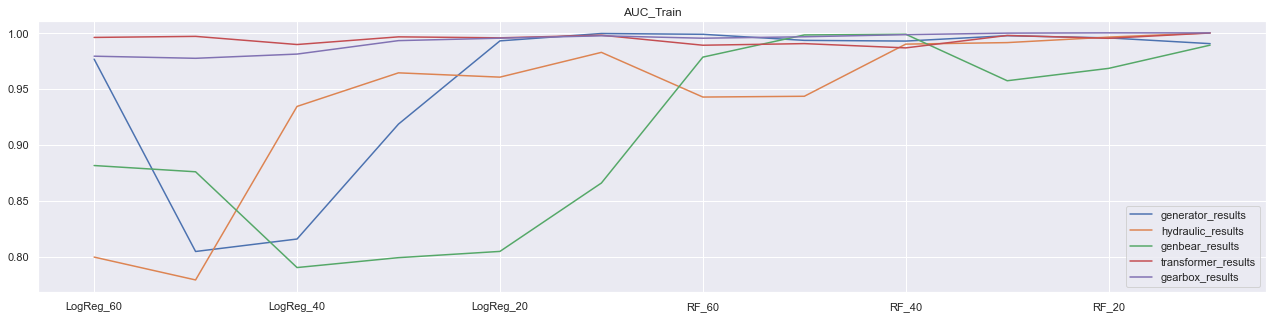

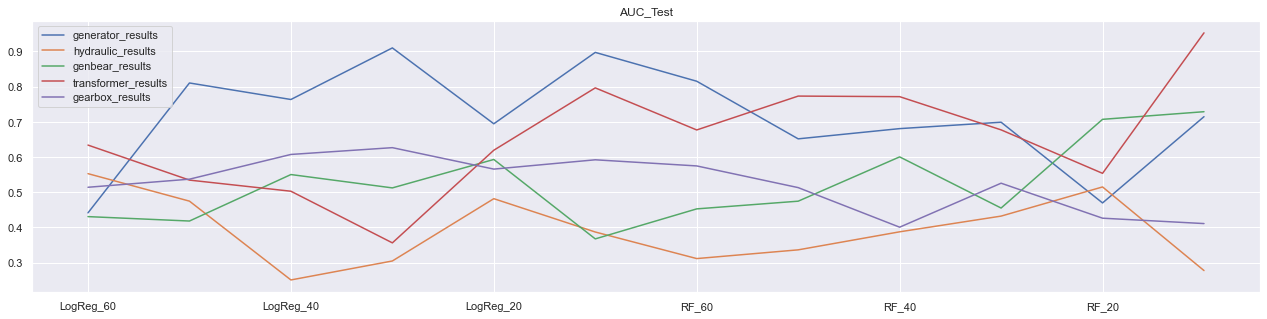

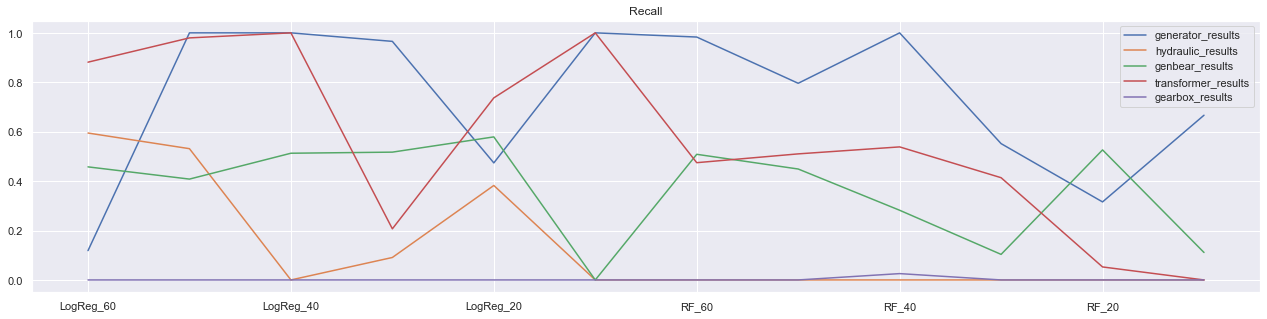

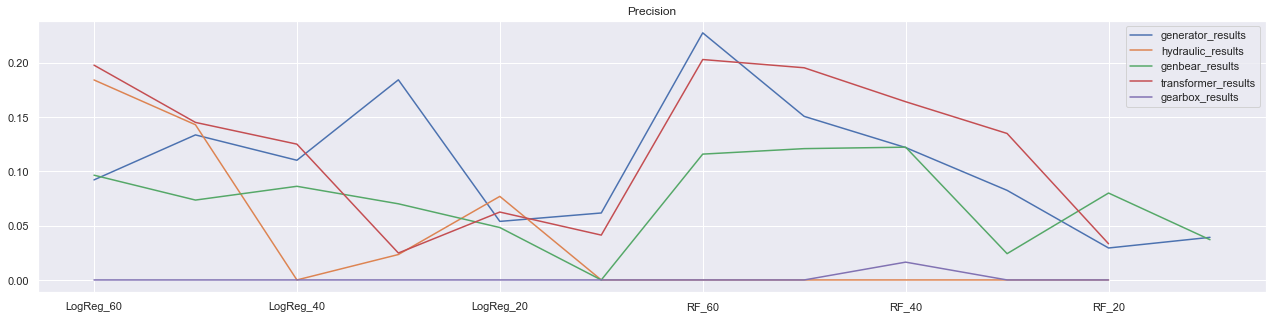

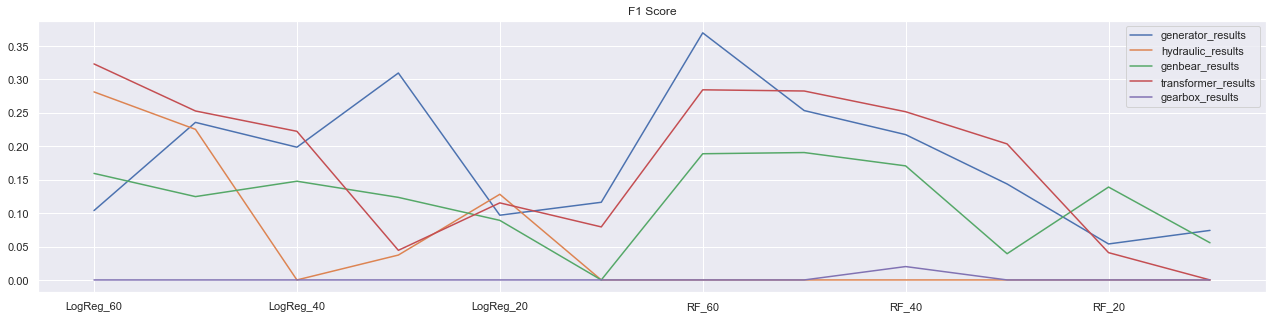

In [465]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(22,5))

for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['AUC_Train', :].plot(label=i)
plt.legend()
plt.title('AUC_Train')
#plt.show()

fig, ax = plt.subplots(figsize=(22,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['AUC_Test', :].plot(label=i)
plt.legend()
plt.title('AUC_Test')
#plt.show()

fig, ax = plt.subplots(figsize=(22,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['Recall', :].plot(label=i)
plt.legend()
plt.title('Recall')
plt.show()


fig, ax = plt.subplots(figsize=(22,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['Precision', :].plot(label=i)
plt.legend()
plt.title('Precision')
plt.show()

fig, ax = plt.subplots(figsize=(22,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['F1 Score', :].plot(label=i)
plt.legend()
plt.title('F1 Score')
plt.show()

 
generator_results RF_60
 


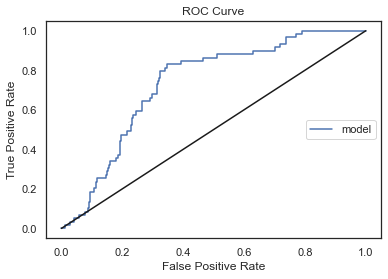

 
generator_results RF_50
 


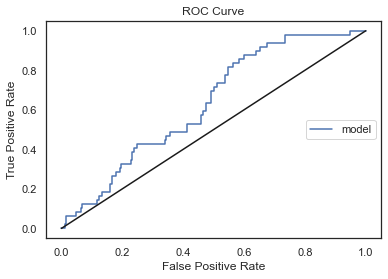

 
generator_results RF_40
 


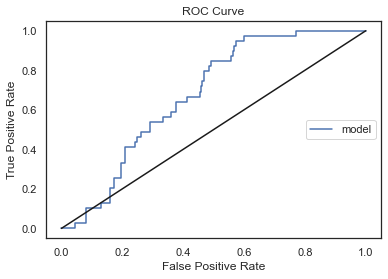

 
generator_results RF_30
 


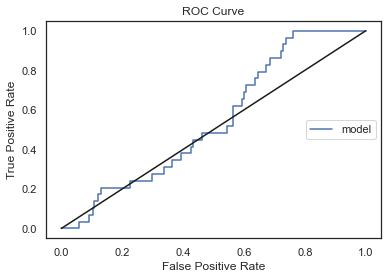

 
generator_results RF_20
 


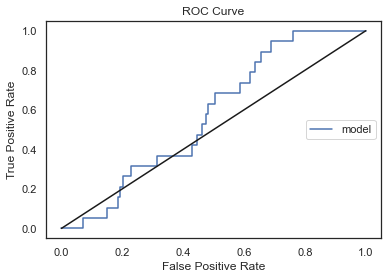

 
generator_results RF_10
 


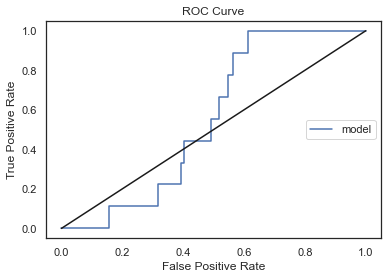

 
generator_results GB_60
 


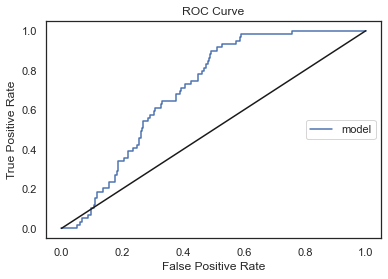

 
generator_results GB_50
 


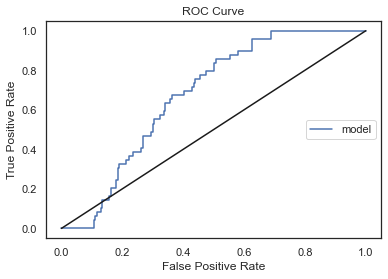

 
generator_results GB_40
 


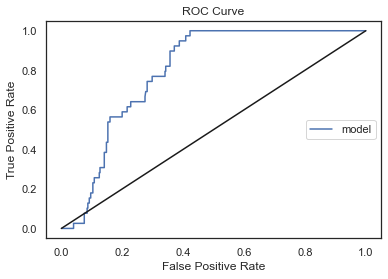

 
generator_results GB_30
 


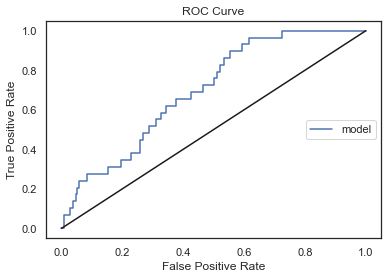

 
generator_results GB_20
 


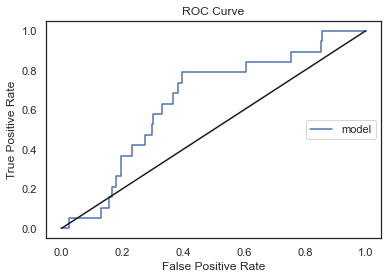

 
generator_results GB_10
 


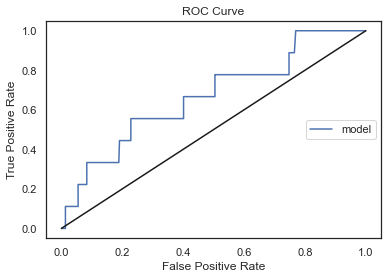

 
hydraulic_results RF_60
 


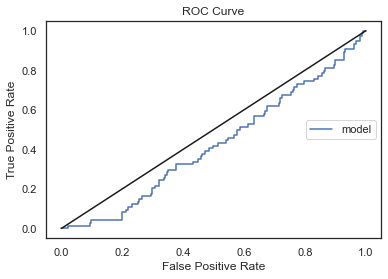

 
hydraulic_results RF_50
 


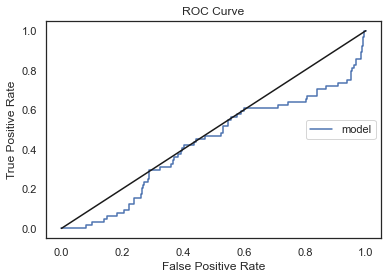

 
hydraulic_results RF_40
 


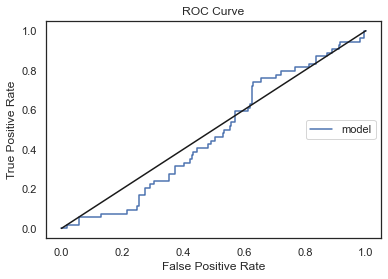

 
hydraulic_results RF_30
 


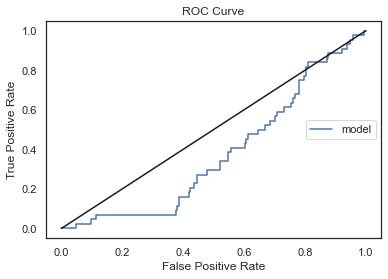

 
hydraulic_results RF_20
 


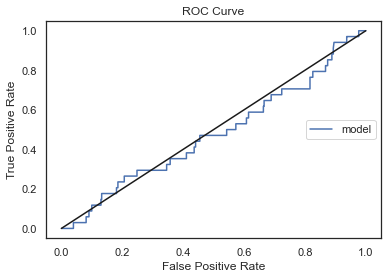

 
hydraulic_results RF_10
 


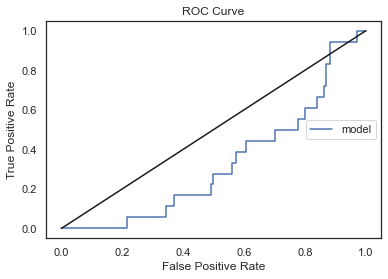

 
hydraulic_results GB_60
 


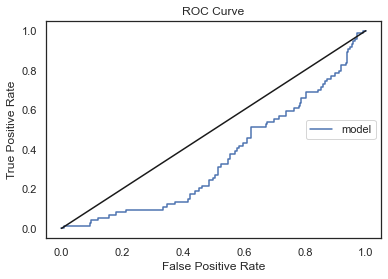

 
hydraulic_results GB_50
 


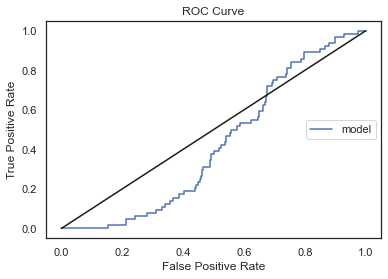

 
hydraulic_results GB_40
 


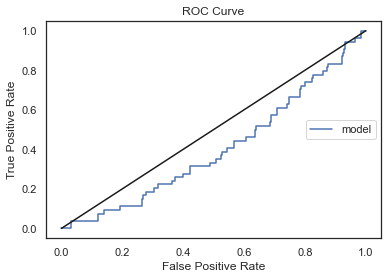

 
hydraulic_results GB_30
 


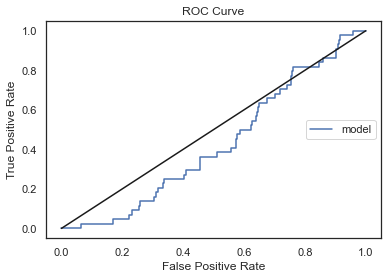

 
hydraulic_results GB_20
 


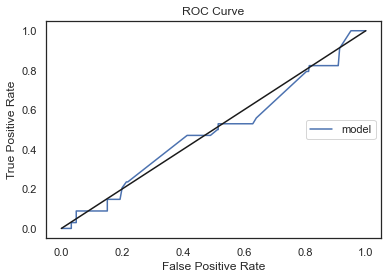

 
hydraulic_results GB_10
 


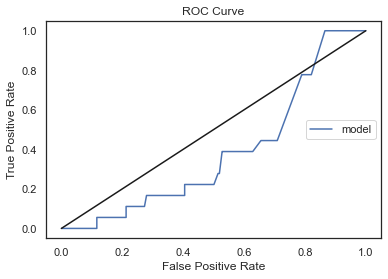

 
genbear_results RF_60
 


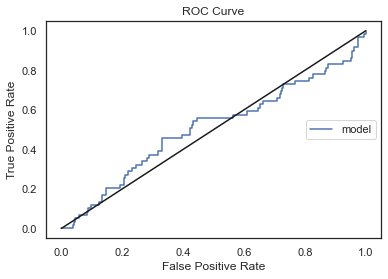

 
genbear_results RF_50
 


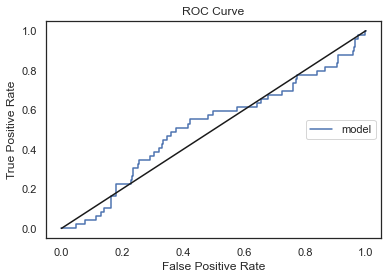

 
genbear_results RF_40
 


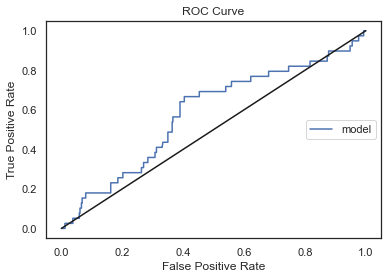

 
genbear_results RF_30
 


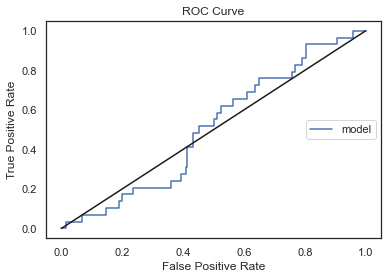

 
genbear_results RF_20
 


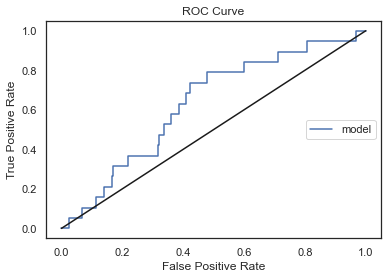

 
genbear_results RF_10
 


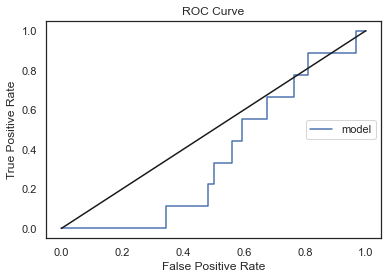

 
genbear_results GB_60
 


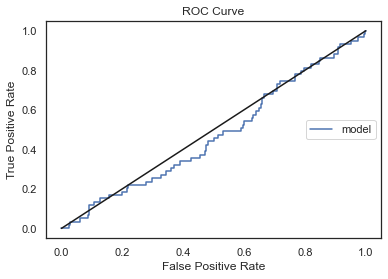

 
genbear_results GB_50
 


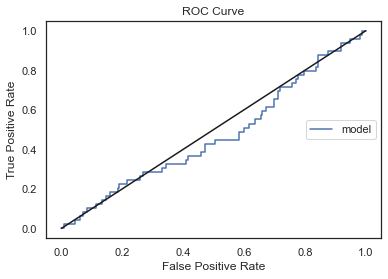

 
genbear_results GB_40
 


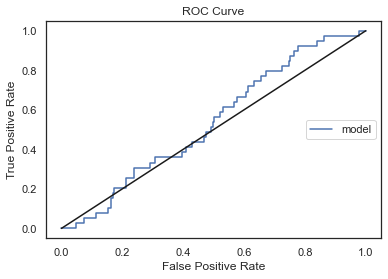

 
genbear_results GB_30
 


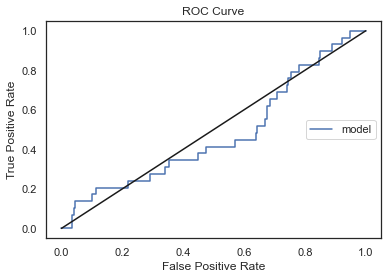

 
genbear_results GB_20
 


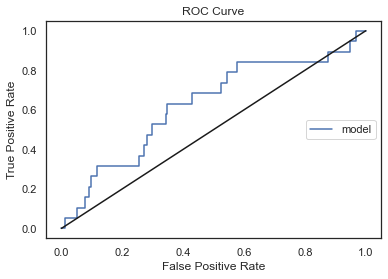

 
genbear_results GB_10
 


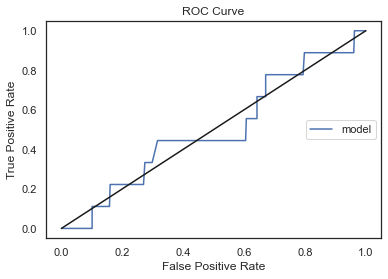

 
transformer_results RF_60
 


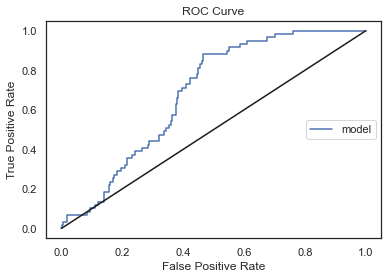

 
transformer_results RF_50
 


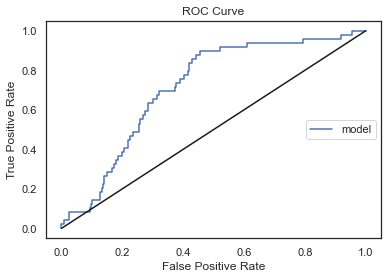

 
transformer_results RF_40
 


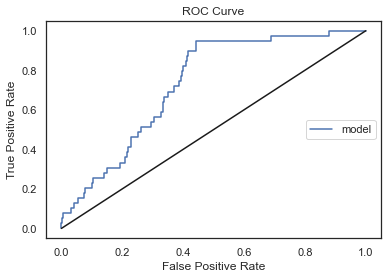

 
transformer_results RF_30
 


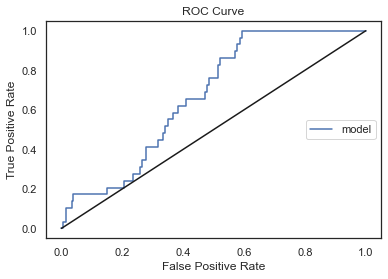

 
transformer_results RF_20
 


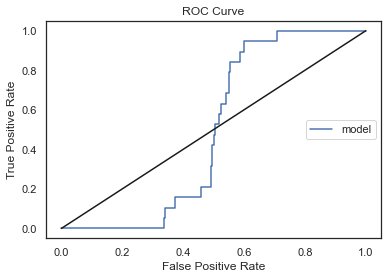

 
transformer_results RF_10
 


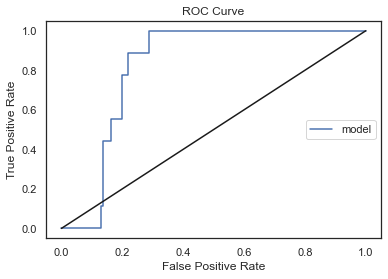

 
transformer_results GB_60
 


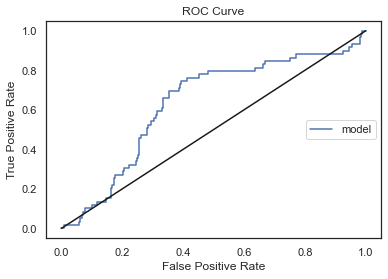

 
transformer_results GB_50
 


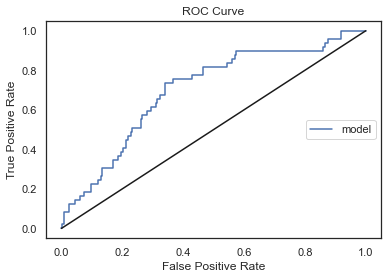

 
transformer_results GB_40
 


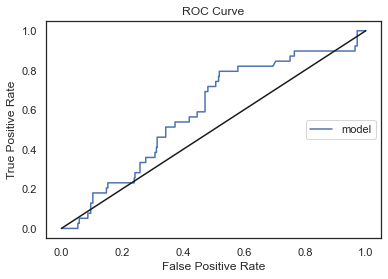

 
transformer_results GB_30
 


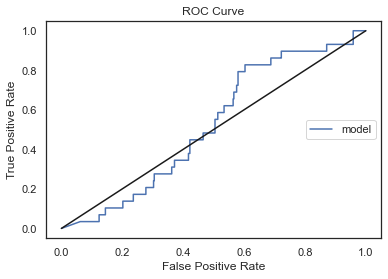

 
transformer_results GB_20
 


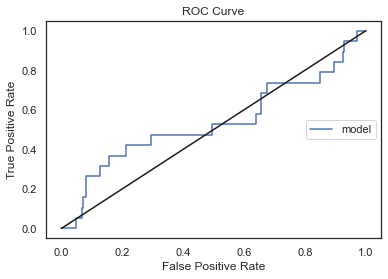

 
transformer_results GB_10
 


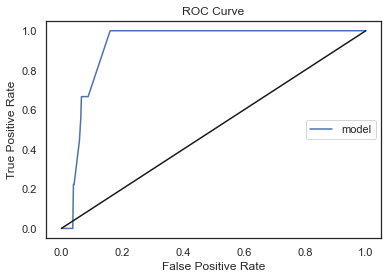

 
gearbox_results RF_60
 


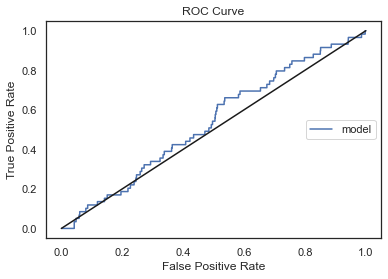

 
gearbox_results RF_50
 


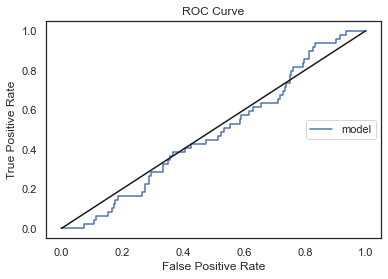

 
gearbox_results RF_40
 


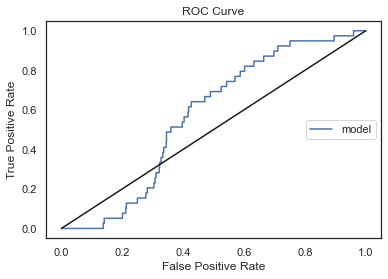

 
gearbox_results RF_30
 


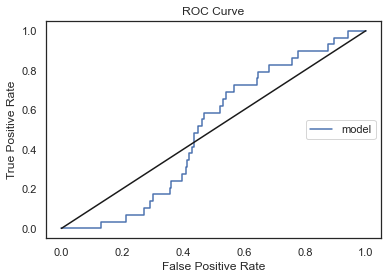

 
gearbox_results RF_20
 


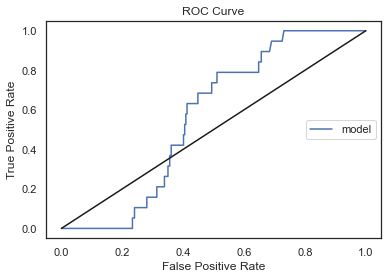

 
gearbox_results RF_10
 


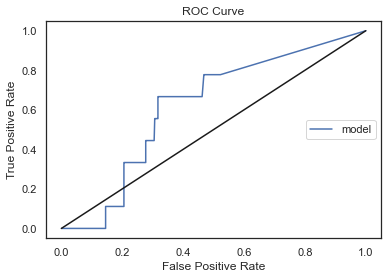

 
gearbox_results GB_60
 


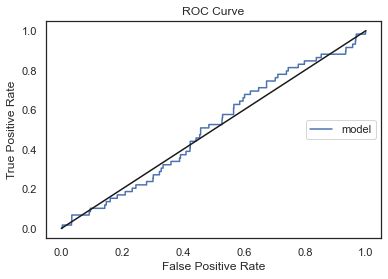

 
gearbox_results GB_50
 


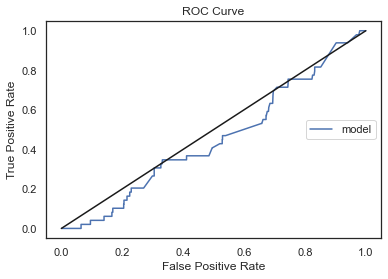

 
gearbox_results GB_40
 


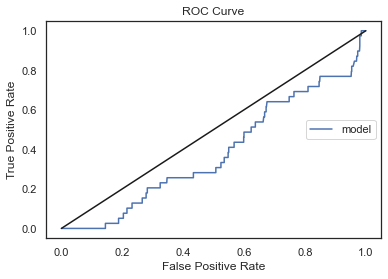

 
gearbox_results GB_30
 


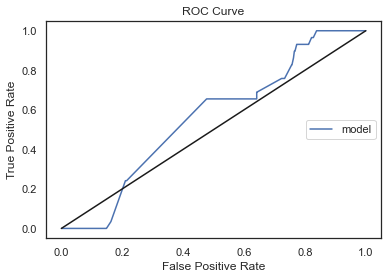

 
gearbox_results GB_20
 


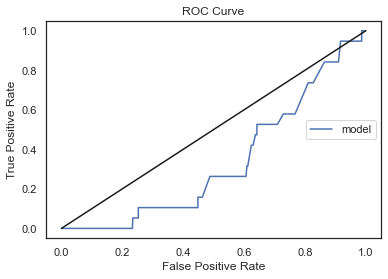

 
gearbox_results GB_10
 


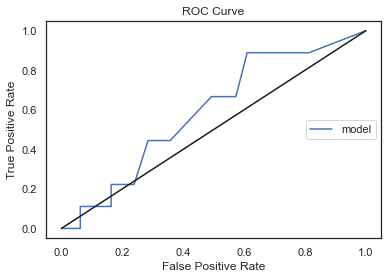

In [410]:
for component in dict_results_by_component.keys():
    for model in dict_mod.keys():
        print(" ")
        print(f'{component+" "+model}')
        print(" ")
        roc_curve_plot (dict_Y_pred_true_by_component[component][model]['test_true'],  dict_Y_pred_true_by_component[component][model]['test_pred']['y_test_prob'].values)
        plt.show()

In [531]:
dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_pred'][dict_Y_pred_true_by_component['generator_results']['LogReg_60']['test_pred']['y_test_pred']==1].min()

y_test_pred    1.000000
y_test_prob    0.191659
dtype: float64

In [242]:
for component in dict_results_by_component.keys():
    for model in dict_mod.keys():
        print(" ")
        print(f'{component+" "+model}')
        print(" ")
        print(conf_matrix ( dict_Y_pred_true_by_component[component][model]['test_true'], dict_Y_pred_true_by_component[component][model]['test_pred']['y_test_pred'].values))
        

 
generator_results LogReg_60
 
Predicted Class    0    1
Actual Class             
0                295  111
1                 57    2
 
generator_results LogReg_30
 
Predicted Class   0    1
Actual Class            
0                42  394
1                 0   29
 
generator_results SVC_60
 
Predicted Class    0    1
Actual Class             
0                306  100
1                 53    6
 
generator_results SVC_30
 
Predicted Class    0   1
Actual Class            
0                394  42
1                 28   1
 
hydraulic_results LogReg_60
 
Predicted Class    0    1
Actual Class             
0                161  230
1                 45   29
 
hydraulic_results LogReg_30
 
Predicted Class    0    1
Actual Class             
0                171  250
1                 22   22
 
hydraulic_results SVC_60
 
Predicted Class    0
Actual Class        
0                391
1                 74
 
hydraulic_results SVC_30
 
Predicted Class    0
Actual Class        
0             

 
generator_results LogReg_60
 


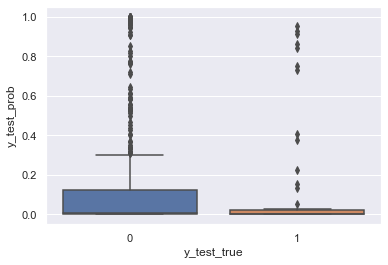

 
generator_results LogReg_50
 


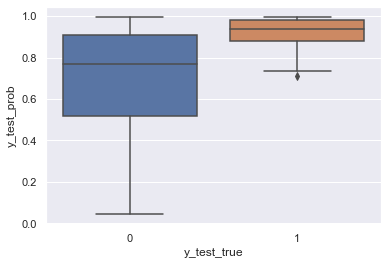

 
generator_results LogReg_40
 


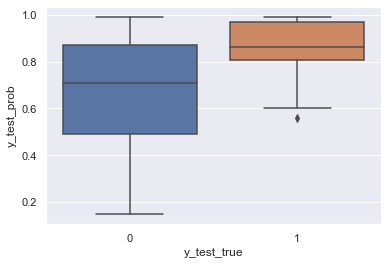

 
generator_results LogReg_30
 


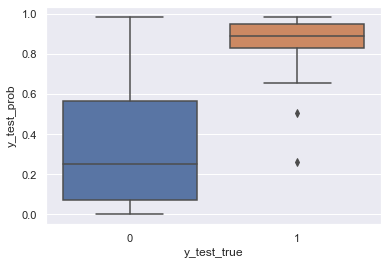

 
generator_results LogReg_20
 


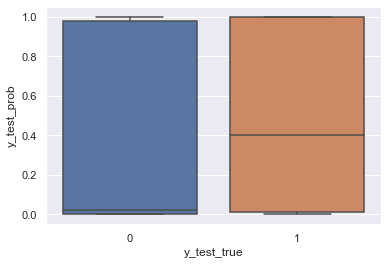

 
generator_results LogReg_10
 


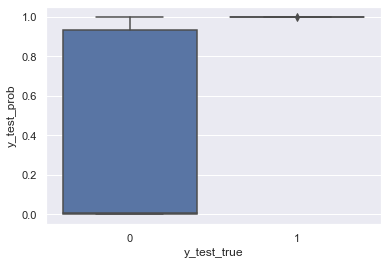

 
generator_results RF_60
 


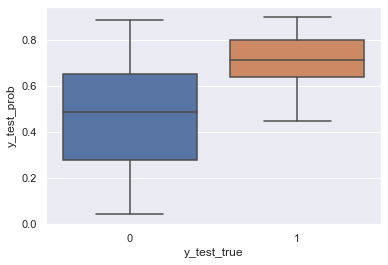

 
generator_results RF_50
 


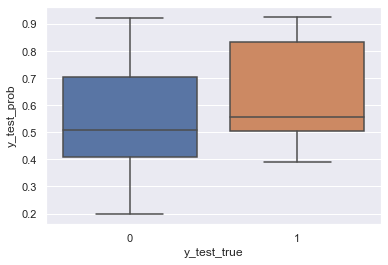

 
generator_results RF_40
 


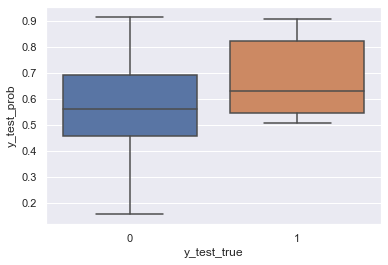

 
generator_results RF_30
 


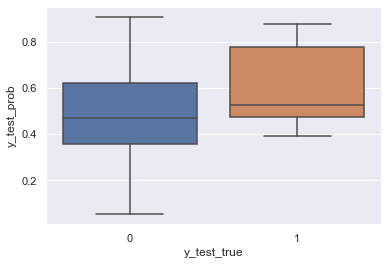

 
generator_results RF_20
 


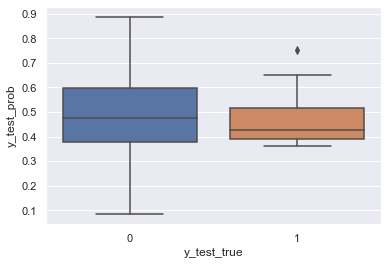

 
generator_results RF_10
 


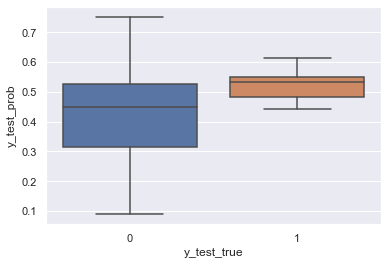

 
hydraulic_results LogReg_60
 


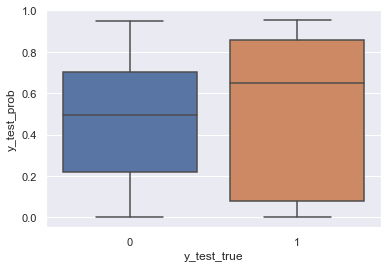

 
hydraulic_results LogReg_50
 


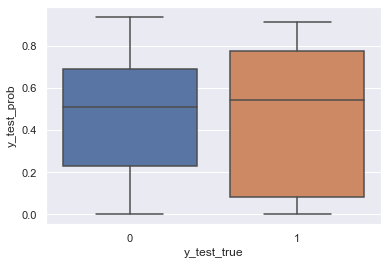

 
hydraulic_results LogReg_40
 


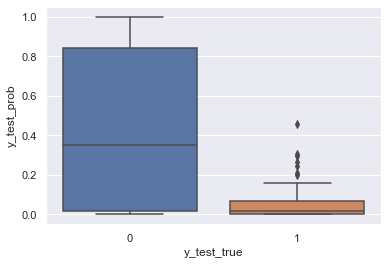

 
hydraulic_results LogReg_30
 


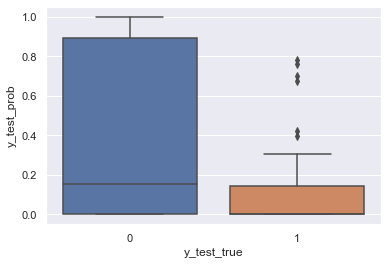

 
hydraulic_results LogReg_20
 


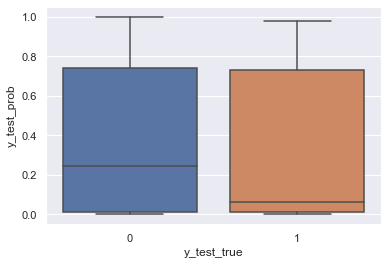

 
hydraulic_results LogReg_10
 


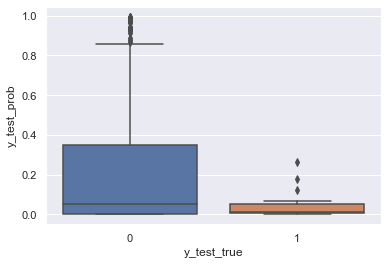

 
hydraulic_results RF_60
 


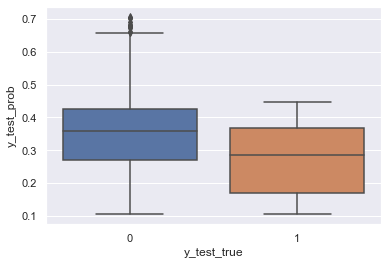

 
hydraulic_results RF_50
 


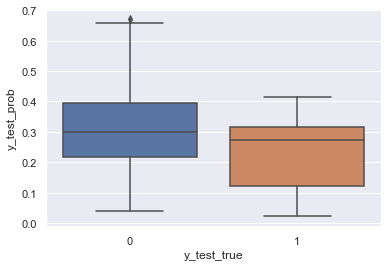

 
hydraulic_results RF_40
 


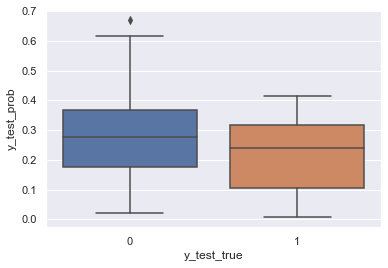

 
hydraulic_results RF_30
 


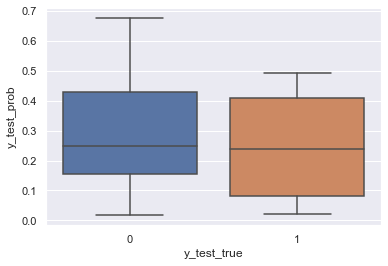

 
hydraulic_results RF_20
 


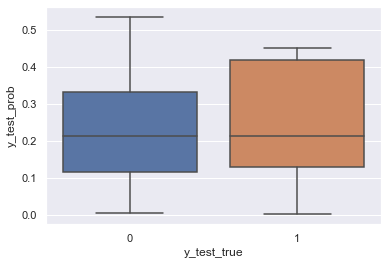

 
hydraulic_results RF_10
 


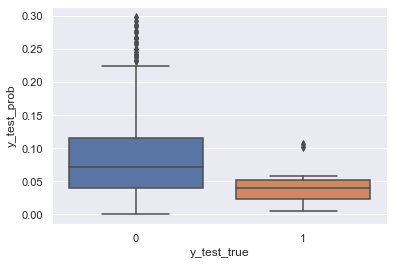

 
genbear_results LogReg_60
 


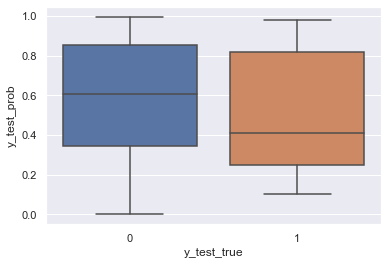

 
genbear_results LogReg_50
 


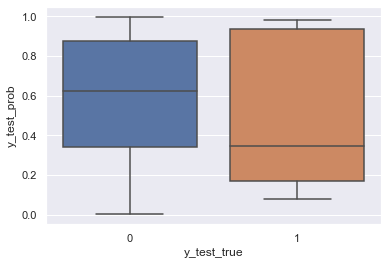

 
genbear_results LogReg_40
 


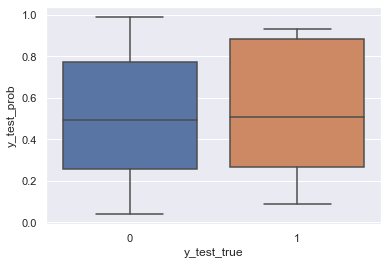

 
genbear_results LogReg_30
 


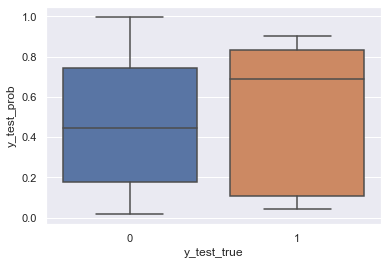

 
genbear_results LogReg_20
 


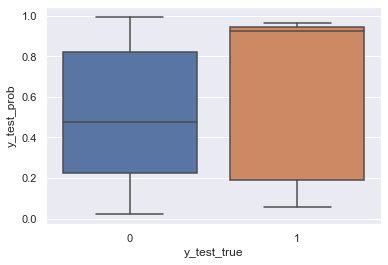

 
genbear_results LogReg_10
 


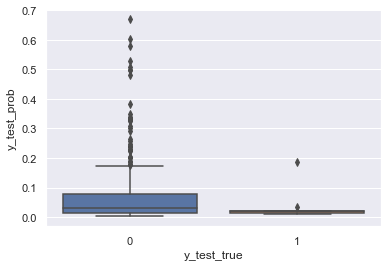

 
genbear_results RF_60
 


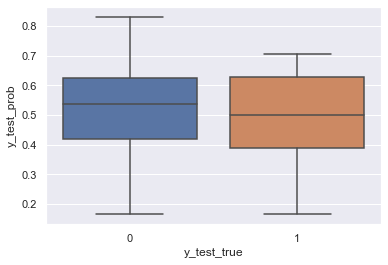

 
genbear_results RF_50
 


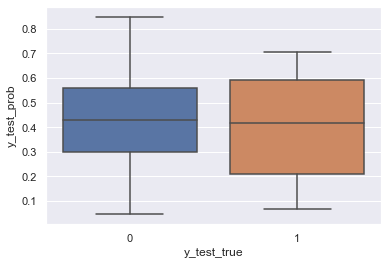

 
genbear_results RF_40
 


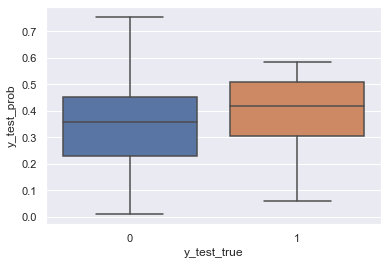

 
genbear_results RF_30
 


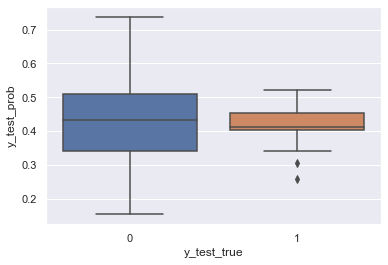

 
genbear_results RF_20
 


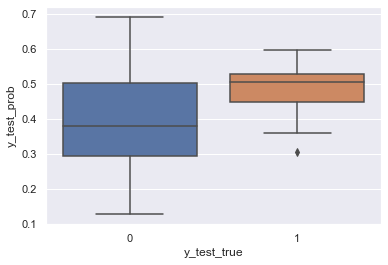

 
genbear_results RF_10
 


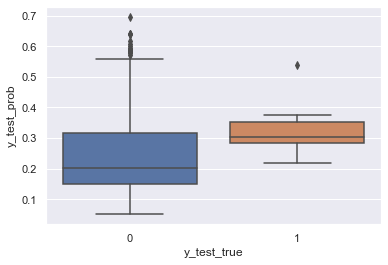

 
transformer_results LogReg_60
 


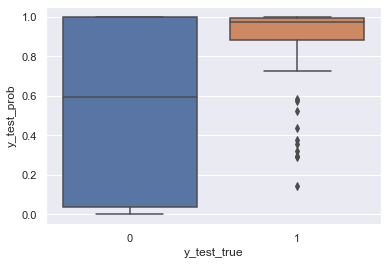

 
transformer_results LogReg_50
 


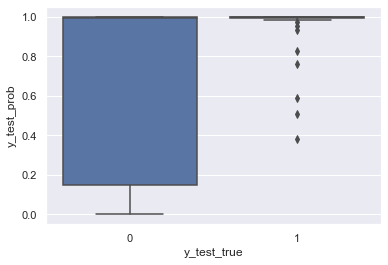

 
transformer_results LogReg_40
 


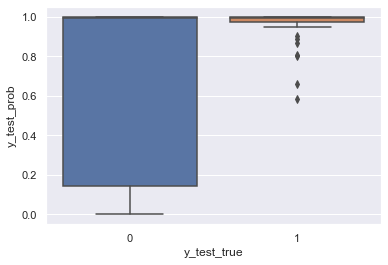

 
transformer_results LogReg_30
 


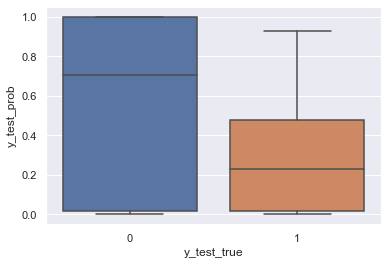

 
transformer_results LogReg_20
 


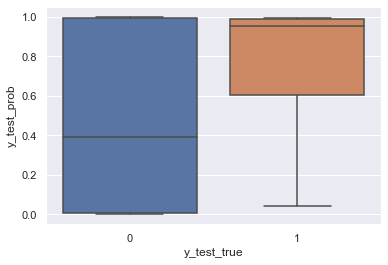

 
transformer_results LogReg_10
 


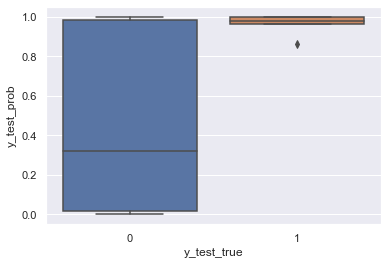

 
transformer_results RF_60
 


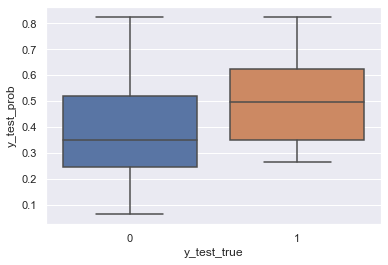

 
transformer_results RF_50
 


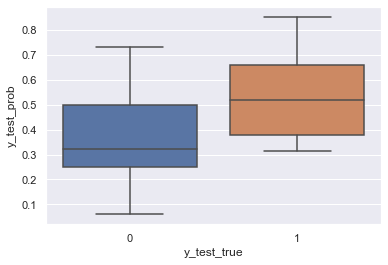

 
transformer_results RF_40
 


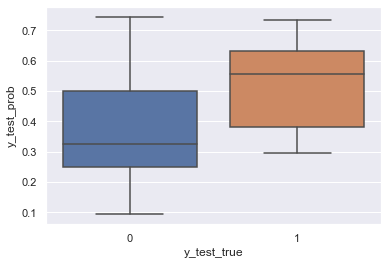

 
transformer_results RF_30
 


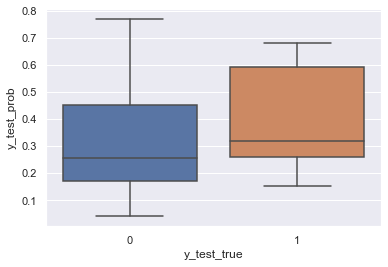

 
transformer_results RF_20
 


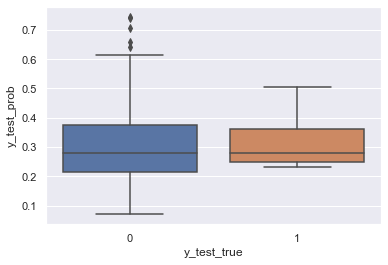

 
transformer_results RF_10
 


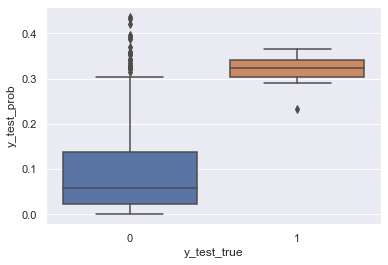

 
gearbox_results LogReg_60
 


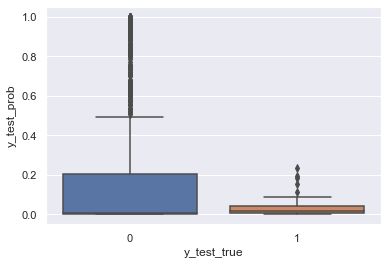

 
gearbox_results LogReg_50
 


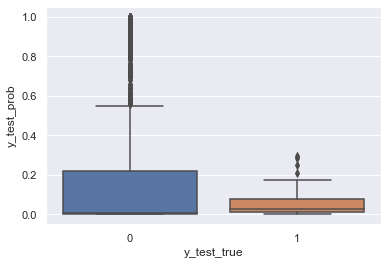

 
gearbox_results LogReg_40
 


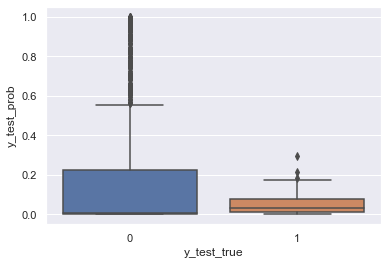

 
gearbox_results LogReg_30
 


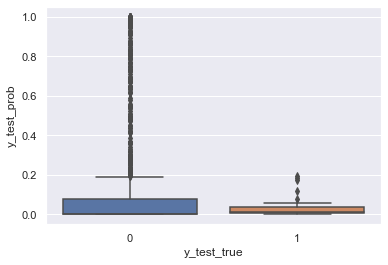

 
gearbox_results LogReg_20
 


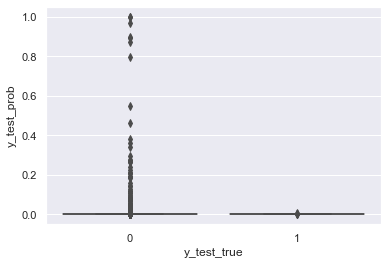

 
gearbox_results LogReg_10
 


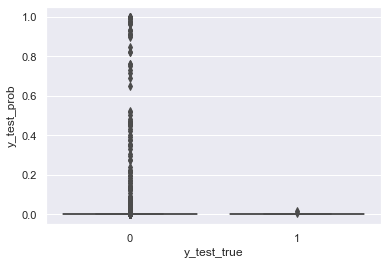

 
gearbox_results RF_60
 


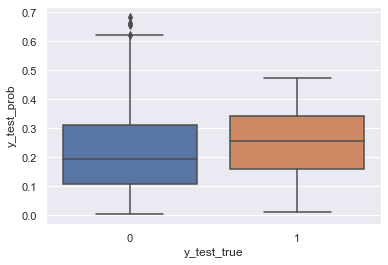

 
gearbox_results RF_50
 


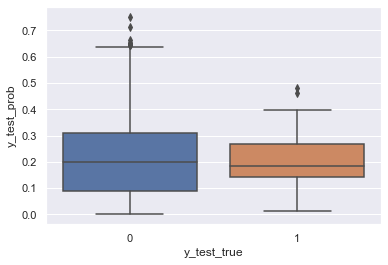

 
gearbox_results RF_40
 


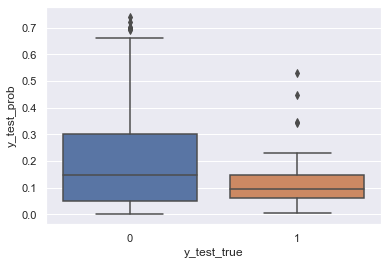

 
gearbox_results RF_30
 


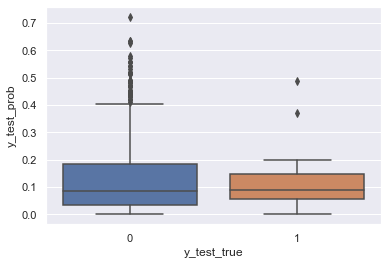

 
gearbox_results RF_20
 


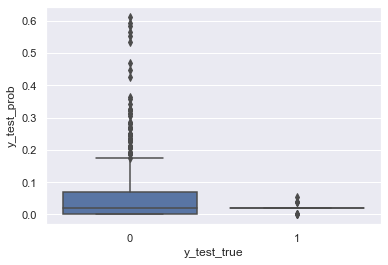

 
gearbox_results RF_10
 


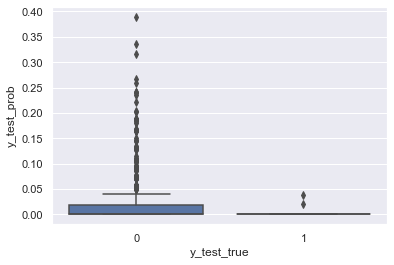

In [466]:
for component in dict_results_by_component.keys():
    for model in dict_mod.keys():
        
        df_boxplot=pd.DataFrame(dict_Y_pred_true_by_component[component][model]['test_true'].values,
        dict_Y_pred_true_by_component[component][model]['test_pred']['y_test_prob']).reset_index().rename(columns={0:'y_test_true'})
        print(" ")
        print(f'{component+" "+model}')
        print(" ")
        sns.boxplot(x="y_test_true", y="y_test_prob", data=df_boxplot)
        
        plt.show()

# Cria de DF para avaliação de métricas

In [58]:
cols= ['Date','Turbine_ID', 'TTF']
poupanca_df = df_test[0][cols]

In [59]:
poupanca_df['y_test'] = y_test

c:\users\ricar\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
poupanca_df['y_pred'] = pred_LogReg.y_pred.values

c:\users\ricar\.venvs\lewagon\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
poupanca_df = poupanca_df.reset_index().drop(columns='index')

In [62]:
def met_poupanca_TP(real, prev):
    if real == prev and real ==1:
        return 1
    else:
        return 0

In [63]:
poupanca_df['TP'] = [
    met_poupanca_TP(poupanca_df.y_test[i], poupanca_df.y_pred[i])
    for i in range(len(poupanca_df.y_pred))
]

In [64]:
def met_poupanca_TN(real, prev):
    if real == prev and real == 0:
        return 1
    else:
        return 0

In [65]:
poupanca_df['TN'] = [
    met_poupanca_TN(poupanca_df.y_test[i], poupanca_df.y_pred[i])
    for i in range(len(poupanca_df.y_pred))
]

In [66]:
def met_poupanca_FP(real, prev):
    if real == 0 and prev == 1:
        return 1
    else:
        return 0

In [67]:
poupanca_df['FP'] = [
    met_poupanca_FP(poupanca_df.y_test[i], poupanca_df.y_pred[i])
    for i in range(len(poupanca_df.y_pred))
]

In [68]:
def met_poupanca_FN(real, prev):
    if real == 1 and prev == 0:
        return 1
    else:
        return 0

In [69]:
poupanca_df['FN'] = [
    met_poupanca_FN(poupanca_df.y_test[i], poupanca_df.y_pred[i])
    for i in range(len(poupanca_df.y_pred))
]

In [70]:
poupanca_df.head()

,Date,Turbine_ID,TTF,y_test,y_pred,TP,TN,FP,FN
0,2017-06-01,T01,0.0,0,0,0,1,0,0
1,2017-06-02,T01,0.0,0,0,0,1,0,0
2,2017-06-03,T01,0.0,0,0,0,1,0,0
3,2017-06-04,T01,0.0,0,0,0,1,0,0
4,2017-06-05,T01,0.0,0,0,0,1,0,0


In [78]:
num_falhas = len(poupanca_df[poupanca_df.TTF.between(0.1 , 1.0)])
num_falhas

1

In [79]:
poupanca_df[poupanca_df.TTF.between(0.1 , 1.0)]

,Date,Turbine_ID,TTF,y_test,y_pred,TP,TN,FP,FN
267,2017-08-21,T07,0.111111,0,0,0,1,0,0


In [80]:
index_list = []
for i in range(num_falhas):
    index_list.append(poupanca_df[poupanca_df.TTF.between(0.1 , 1.0)].index[i])
print(index_list)

[267]


In [81]:
cf_numbers = {
    'TP': 0,
    'TN': 0,
    'FP': 0,
    'FN': 0,
}

In [102]:
for key in cf_numbers:
    print(key)

TP
TN
FP
FN


In [104]:
# Para as ocorrências
ocorrencias = poupanca_df[poupanca_df['y_test'] == 1]

for ind in range(len(index_list)):
    for key in cf_numbers:
        cf_numbers[key] += ocorrencias.loc[:index_list[ind]][key].sum()
    if cf_numbers['TP'] >= 1:
        cf_numbers['TP'] = 1
        cf_numbers['TN'] = 0
        cf_numbers['FP'] = 0
        cf_numbers['FN'] = 0
    elif cf_numbers['FN'] >= 1:
        cf_numbers['TP'] = 0
        cf_numbers['TN'] = 0
        cf_numbers['FP'] = 0
        cf_numbers['FN'] = 1
    print(cf_numbers)

dias_primeiro_TP = ocorrencias.loc[ocorrencias[ocorrencias.TP == 1].index[0]].TTF.astype(int)
dias_primeiro_TP

SyntaxError: can't assign to literal (<ipython-input-104-83a1efd3745f>, line 8)

In [87]:
# Para as ocorrências
ocorrencias = poupanca_df[poupanca_df['y_test'] == 1]

for ind in range(len(index_list)):
    if ind == 0:
        cf_numbers['TP'] += ocorrencias.loc[:index_list[ind]]['TP'].sum()
        cf_numbers['TN'] += ocorrencias.loc[:index_list[ind]]['TN'].sum()
        cf_numbers['FP'] += ocorrencias.loc[:index_list[ind]]['FP'].sum()
        cf_numbers['FN'] += ocorrencias.loc[:index_list[ind]]['FN'].sum()
    else:
        cf_numbers['TP'] += ocorrencias.loc[index_list[ind - 1]:index_list[ind]]['TP'].sum()
        cf_numbers['TN'] += ocorrencias.loc[index_list[ind - 1]:index_list[ind]]['TN'].sum()
        cf_numbers['FP'] += ocorrencias.loc[index_list[ind - 1]:index_list[ind]]['FP'].sum()
        cf_numbers['FN'] += ocorrencias.loc[index_list[ind - 1]:index_list[ind]]['FN'].sum()
    if cf_numbers['TP'] >= 1:
        cf_numbers['TP'] = 1
        cf_numbers['TN'] = 0
        cf_numbers['FP'] = 0
        cf_numbers['FN'] = 0
    elif cf_numbers['FN'] >= 1:
        cf_numbers['TP'] = 0
        cf_numbers['TN'] = 0
        cf_numbers['FP'] = 0
        cf_numbers['FN'] = 1
    print(cf_numbers)

dias_primeiro_TP = ocorrencias.loc[ocorrencias[ocorrencias.TP == 1].index[0]].TTF.astype(int)
dias_primeiro_TP

{'TP': 1, 'TN': 0, 'FP': 0, 'FN': 0}


15

In [83]:
# Para as não ocorrências
ocorrencias = poupanca_df[poupanca_df['y_test'] == 0]

for ind in range(len(index_list)):
    if ind == 0:
        cf_numbers['TP'] += ocorrencias.loc[:index_list[ind]]['TP'].sum()
        cf_numbers['TN'] += ocorrencias.loc[:index_list[ind]]['TN'].sum()
        cf_numbers['FP'] += ocorrencias.loc[:index_list[ind]]['FP'].sum()
        cf_numbers['FN'] += ocorrencias.loc[:index_list[ind]]['FN'].sum()
    else:
        cf_numbers['TP'] += ocorrencias.loc[index_list[ind - 1]:index_list[ind]]['TP'].sum()
        cf_numbers['TN'] += ocorrencias.loc[index_list[ind - 1]:index_list[ind]]['TN'].sum()
        cf_numbers['FP'] += ocorrencias.loc[index_list[ind - 1]:index_list[ind]]['FP'].sum()
        cf_numbers['FN'] += ocorrencias.loc[index_list[ind - 1]:index_list[ind]]['FN'].sum()
    if cf_numbers['TP'] > 1:
        cf_numbers['TP'] = 1
        cf_numbers['TN'] = 0
        cf_numbers['FP'] = 0
        cf_numbers['FN'] = 0
    elif cf_numbers['TP'] > 1:
        cf_numbers['TP'] = 0
        cf_numbers['TN'] = 0
        cf_numbers['FP'] = 0
        cf_numbers['FN'] = 1
    print(cf_numbers)

{'TP': 1, 'TN': 228, 'FP': 2, 'FN': 0}


In [89]:
cost_matrix_dict = {
    'GEARBOX': {
        'Replacement_Cost': 100000,
        'Repair_Cost': 20000,
        'Inspection_cost': 5000
    },
    'GENERATOR': {
        'Replacement_Cost': 60000,
        'Repair_Cost': 15000,
        'Inspection_cost': 5000
    },
    'GENERATOR_BEARING': {
        'Replacement_Cost': 30000,
        'Repair_Cost': 12500,
        'Inspection_cost': 4500
    },
    'TRANSFORMER': {
        'Replacement_Cost': 50000,
        'Repair_Cost': 3500,
        'Inspection_cost': 1500
    },
    'HYDRAULIC_GROUP': {
        'Replacement_Cost': 20000,
        'Repair_Cost': 3000,
        'Inspection_cost': 2000
    }
}

In [90]:
Savings = -cost_matrix_dict['GENERATOR']['Inspection_cost'] * cf_numbers[
    'FP']
Savings = Savings + -cost_matrix_dict['GENERATOR'][
    'Replacement_Cost'] * cf_numbers['FN']
Savings = Savings + cost_matrix_dict['GENERATOR']['Replacement_Cost'] - (
    cost_matrix_dict['GENERATOR']['Repair_Cost'] +
    (cost_matrix_dict['GENERATOR']['Replacement_Cost'] -
     cost_matrix_dict['GENERATOR']['Repair_Cost']) *
    (1 - (dias_primeiro_TP / 60)))

In [91]:
Savings

11250.0

In [112]:
dprep.metrics_create_df(df_test[0], y_test, pred_LogReg.y_pred.values)

11250.0